### PRACTICA CSGO CLASIFICACIÓN

En esta practica vamos a estudiar las rondas del csgo para poder predecir que equipo podrá ganar una ronda. Las variables que vamos a manejar más a tener en cuenta son las siguientes:

    - time_left: Tiempo de juego restante
    - ct_score: Puntuacion del equipo antiterrorista (CT).
    - t_score: Puntuacion del equipo terrorista (T).
    - map: Mapa en el que se juega la ronda | E.g. de_dust2, de_inferno and de_overpass.
    - bomb_planted: Booleano si la bomba ha sido puesta o no | False = No, True = Yes.
    - ct_health: Salud total de todos los jugadores CT | Salud del jugador en el rango 0-100.
    - t_health: Salud total de todos los jugadores T | Salud del jugador en el rango 0-100.
    - ct_armor: Armadura total de todos los jugadores CT.
    - t_armor: Armadura total de todos los jugadores T.
    - ct_money: Dinero total de todos los jugadores CT.
    - t_money: Dinero total de todos los jugadores T.
    - ct_helmets: Numero de cascos de todos los jugadores CT.
    - t_helmets: Numero de cascos de todos los jugadores T.
    - ct_defuse_kits: Numero de kits de desmantelamiento del equipo CT.
    - ct_players_alive: Numero de jugadores vivos en el equipo CT. Rango de 0 a 5.
    - t_players_alive: Numero de jugadores vivos en el equipo T. Rango de 0 a 5.
    - ct_weapon_X: Numero de armas del modelo X en el equipo CT, E.g. Ak47, Deagle and UMP45.
    - t_weapon_X: Numero de armas del modelo X en el equipo T, E.g. Ak47, Deagle and UMP45.
    - ct_grenade_X: Numero de granadas en el equipo CT, E.g. HeGrenade, Flashbang.
    - t_grenade_X: Numero de granadas en el equipo T. E.g. HeGrenade, Flashbang.
    - round_winner: Equipo ganador de la ronda. CT = Counter-Terrorist, T = Terrorist Variable objetivo.

#### Librerias base para la practica


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import sklearn.compose
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from scipy import stats

### Definición de funciones auxiliares

In [2]:
def one_hot_encoding(data):
    col_names = []
    
    for x in data.columns:
        if data[x].dtype == 'bool':
            cols = [x + '_false', x + '_true']
            for i in range (0, len(cols)):
                col_names.append(cols[i])
        elif data[x].dtype == 'object':
            cols = data[x].unique()
            cols.sort()
            for i in range(0, len(cols)):
                col_names.append(cols[i])
    
    enc = OneHotEncoder(sparse=False).fit(data)
    transformed_data = enc.transform(data)
    
    one_hot_data = pd.DataFrame(data=transformed_data, columns=col_names)
    return one_hot_data
    
def robust_scaler(data):
    col_names = data.columns
    
    X = np.array(data)
    robust_data = RobustScaler().fit_transform(X)
    return pd.DataFrame(columns=col_names, data=robust_data)


def obtain_corr(data, cols):
    result = pd.DataFrame()
    
    for colx in cols:
        for coly in data.columns:
            if colx in coly:
                result[coly] = data[coly]
    result['round_winner'] = data_train['round_winner']
    return result

def find_unused_weapons(data):
    cols = []
    for col in data.columns:
        if 'weapon' in col:
            if data[data[col] == 1].empty:
                cols.append(col)
    return cols

def write_results(prediction):
    results = pd.DataFrame(prediction, columns=['round_winner'])
    results['id'] = data_test['id']
    results.to_csv('predicciones.csv', columns=results.columns.values, index=False)

### PARTE 1 CARGA DE LOS DATOS

In [3]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

## Parte 2 preprocesamiento de los datos

Tenemos que tener en cuenta que según el enunciado, se nos dan los datos preprocesados y se nos dice que las rondas son independientes entre sí es decir pueden ser tratadadas de manera individual.

Pese a estar preprocesados aquí lo primero que vamos a hacer es dividir los datos por los tipos que tiene cada uno, vamos a separar las variables categoricas de las variables cuantitativas y vamos a aplicar un **robust scaler** para que todos los parametros cuantitativos esten en la misma escala y **one hot encoding** a las variables cualitativas.

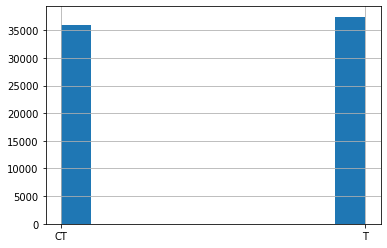

In [4]:
data_train['round_winner'].hist()

Se puede apreciar en el histograma que estan más o menos repartidas las partidas que ha ganado cada uno de forma equitativa entonces esto no nos dice mucho.

A la hora de buscar outliers solo se pueden ver en tiempo, dinero y score ya que de todas las variables que tenemos en el conjunto de datos son las únicas que no estan como tal acotadas

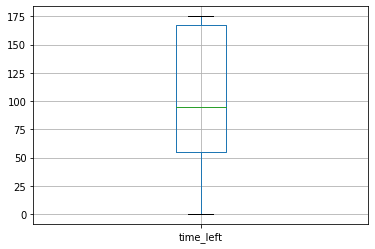

In [44]:
data_train.boxplot('time_left')

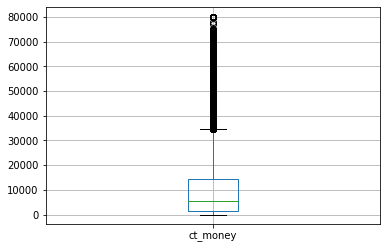

In [48]:
data_train.boxplot('ct_money')

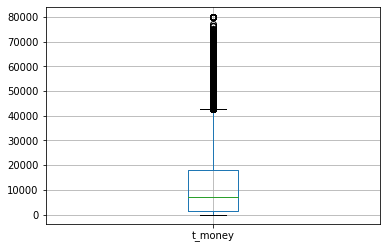

In [47]:
data_train.boxplot('t_money')

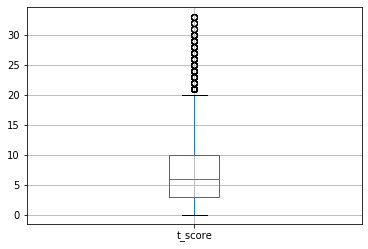

In [50]:
data_train.boxplot('t_score')

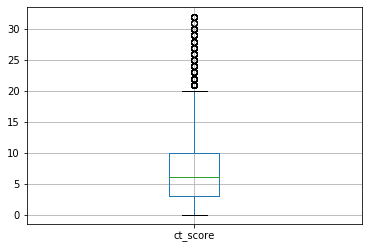

In [51]:
data_train.boxplot('ct_score')

En la variable tiempo no observamos ningún outlier pero en las variables que representan el dinero y el score de cada equipo se puede ver en los boxplot o diagramas de caja y bigotes que existe un gran número de estos mismos. Entonces los modelos de clasificación que sean lineales van a fallar mucho por culpa de esto.

In [53]:
data_train = data_train.dropna()
corr = data_train.corr()
corr.style.background_gradient(cmap='coolwarm')

In [4]:
unused_weapons = find_unused_weapons(data_train)
data_train = data_train.drop(columns=unused_weapons)
unused_weapons

['ct_weapon_bizon',
 'ct_weapon_g3sg1',
 't_weapon_m249',
 'ct_weapon_negev',
 'ct_weapon_r8revolver',
 'ct_weapon_sawedoff',
 't_weapon_scar20']

In [5]:
obj_var = data_train['round_winner']
data_train = data_train.drop(columns=['round_winner', 'round_winner.1'])

categoric_vars = pd.DataFrame()
cuant_vars = pd.DataFrame()

for x in data_train.columns:
    if data_train[x].dtype == 'object' or data_train[x].dtype == 'bool':
        categoric_vars[x] = data_train[x]
    elif data_train[x].dtype == 'float64':
        cuant_vars[x] = data_train[x]


In [6]:
transformed_categoric_vars = one_hot_encoding(categoric_vars)
transformed_cuant_vars = robust_scaler(cuant_vars)

X = pd.concat([transformed_categoric_vars, transformed_cuant_vars], sort=False, axis=1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, obj_var, test_size = 0.2, random_state = 43)

### CONCLUSIÓN DEL PREPROCESAMIENTO
Despues de estudiar la correlación entre variables usando el coeficiente de pearson, que es el que usa pandas por defecto para hacer el calculo de la correlación, nos encontramos con las siguientes variables que no aportan ninguna significación ya que representar armas que nunca fueron usadas en ninguna de las partidas de las cuales esta compuesto nuestro conjunto de datos: 
 - ct_weapon_g3sg1
 - t_weapon_m249
 - ct_weapon_bizon
 - ct_weapon_negev
 - ct_weapon_r8revolver
 - ct_weapon_sawedoff
 - t_weapon_scar20

Como no aportan nada al modelo podemos eliminarlas en el preproceso de los datos. A su vez si obsevarmos la gigante matriz de correlación de los datos nos encontramos con que hay variables que apenas aportan significado alguno al modelo y que podrían llegar a ser eliminadas sin sesgar los datos pero aun no hemos visto reducción de dimensiones en clase y he preferido no hacerlo manualmente por el número tan grande de variables que manejamos.

### PARTE 3 SELECCIÓN DEL MODELO
Antes de probar los modelos aplicamos el mismo preprocesado a los datos de test que al conjunto de entrenamiento, vamos a probar la mayoría de los modelos vistos en clase.

In [8]:
data_test = data_test.drop(columns=unused_weapons)

categoric_vars = pd.DataFrame()
cuant_vars = pd.DataFrame()

for x in data_test.columns:
    if data_test[x].dtype == 'object' or data_test[x].dtype == 'bool':
        categoric_vars[x] = data_test[x]
    elif data_test[x].dtype == 'float64':
        cuant_vars[x] = data_test[x]


transformed_categoric_vars = one_hot_encoding(categoric_vars)
transformed_cuant_vars = robust_scaler(cuant_vars)

X_TEST = pd.concat([transformed_categoric_vars, transformed_cuant_vars], sort=False, axis=1)

### GRID SEARCH FOR HYPERPARAMETERS
He optado por esta opción porque para buscar los hiperparametros aunque no incluya en la libreta los resultados de las mismas ya que directamente los copie para entrenar los modelos. 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def get_adjusted_params(params, model):
    gs = GridSearchCV(model, params, n_jobs = -1, verbose= 1 , cv=3)
    gs.fit(x_train, y_train)
    return pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

def get_random_adjusted_params(params, model):
    rs = RandomizedSearchCV(model, params, n_jobs = -1, verbose = 1, cv=3)
    rs.fit(x_train, y_train)
    return pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')

### REGRESIÓN LOGISTICA

In [52]:
from sklearn.linear_model import LogisticRegression

log_regression = LogisticRegression(random_state=43, solver = 'lbfgs', max_iter = 500).fit(x_train, y_train)
classification = log_regression.predict(x_test)

metrics.f1_score(classification, y_test, average='macro')


0.7467372095589282

### SUPPORT VECTOR MACHINES

In [33]:
from sklearn import svm

svc = svm.LinearSVC(random_state=43, max_iter = 8000).fit(x_train, y_train)
classification = svc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.7468185208107625

### KNN CLASSIFIER

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3).fit(x_train, y_train)
classification = knn.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.8168870650399629

### NEAREST CENTROID CLASSIFIER

In [62]:
from sklearn.neighbors import NearestCentroid
ncc = NearestCentroid().fit(x_train, y_train)
classification = ncc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.7209064913253237

### NAIVE-BAYES

In [38]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train, y_train)
classification = gnb.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.622981713655429

### STOCHASTIC GRADIENT DESCENT CLASSIFIER

In [27]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500).fit(x_train, y_train)
classification = sgd.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.7476901399941059

### DECISION TREES

In [65]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion': ('gini', 'entropy'),
    'max_depth': np.arange(3, 30, 2),
    'splitter': ('best', 'random'),
    'min_samples_split': np.arange(2, 30, 2)
}

dtc = DecisionTreeClassifier(random_state=43)
best_params = get_random_adjusted_params(params, dtc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [67]:
params_for_tree = best_params[best_params['rank_test_score'] == 1]['params']
params_for_tree = params_for_tree.tolist()
params_for_tree = params_for_tree[0]

dtc = DecisionTreeClassifier(**params_for_tree).fit(x_train, y_train)
classification = dtc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.7628902610534254

### RANDOM FOREST
En una primera aproximación he intentado obtener los mejores hiperparametros usando los modelos de busqueda vistos en clase pero el modelo GridSearchCV es demasiado costoso para tener poder utilizarlo aquí, usando el modelo RandomizedSearchCV no obtenia mucha mejor con respecto a los arboles de decisión y los ajuste manualmente.

In [69]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(2, 40, 1),
    'min_samples_leaf': np.arange(2, 20, 2)
}

rf = RandomForestClassifier(criterion='gini', n_jobs=-1, max_features='auto' ,random_state=43)
params = get_random_adjusted_params(params, rf)

params = params[best_params['rank_test_score'] == 1]['params']
params = params.tolist()
params = params[0]

rf = RandomForestClassifier(criterion='gini', n_jobs=-1, max_features='auto' ,random_state=43, **params).fit(x_train, y_train)
classification = rf.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\jonia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


0.7907701197837504

Dicho lo anterior este es si sería mi random forest classifier entrenado con los parametros ajustados manualmente.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc_params = {
    'criterion': 'entropy',
    'n_estimators': 300,
    'min_samples_leaf': 6,
    'max_depth': 29,
    'max_features': 'auto'
}

rf = RandomForestClassifier(**rfc_params, n_jobs=-1, random_state=43).fit(x_train, y_train)
classification = rf.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.8120321835001532

### BAGGING CLASSIFIER

In [40]:
from sklearn.ensemble import BaggingClassifier

params = {
    'max_samples': 0.05,
    'n_estimators': 500,
    'base_estimator': dtc,
    'n_jobs': -1,
    'random_state': 43 
}

bagc = BaggingClassifier(**params).fit(x_train, y_train)
classification = bagc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')


NameError: name 'dtc' is not defined

In [88]:
params = {
    'max_samples': 0.05,
    'n_estimators': 500,
    'base_estimator': knn,
    'n_jobs': -1,
    'random_state': 43 
}

bagc = BaggingClassifier(**params).fit(x_train, y_train)
classification = bagc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')


0.7626814192087996

In [39]:
params = {
    'max_samples': 0.05,
    'n_estimators': 500,
    'base_estimator': rf,
    'n_jobs': -1,
    'random_state': 43 
}

bagc = BaggingClassifier(**params).fit(x_train, y_train)
classification = bagc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

NameError: name 'BaggingClassifier' is not defined

### GRADIENT BOOSTING CLASSIFIER

In [12]:
from sklearn.ensemble import GradientBoostingClassifier


gbc_params = {
    'n_estimators': 500,
    'max_depth': 29,
    'subsample': 0.8,
    'learning_rate': 0.5
}
gbc = GradientBoostingClassifier(**gbc_params, random_state=43).fit(x_train, y_train)
classification = gbc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.8532695475484705

In [71]:
from sklearn.ensemble import AdaBoostClassifier

params = {
    'n_estimators': np.arange(50, 500, 50),
    'learning_rate': np.arange(0.5, 1, 0.1)
}

abc = AdaBoostClassifier(random_state=43)
best_params_abc = get_random_adjusted_params(params, abc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
abc_params = best_params_abc['params'][0]
abc = AdaBoostClassifier(**abc_params, random_state=43, base_estimator=dtc).fit(x_train, y_train)
classification = abc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

{'n_estimators': 350, 'learning_rate': 0.7}


0.8588621674973245

### MODELO FINAL
El modelo final para esta practica elegido es **AdaBoostClassifier** pero cambiando el estimador base por un **Random Forest** que previamente he entrenado en esta práctica. 

El algortimo AdaBoost consiste ajustar secuencias de aprendizajes debiles usando versiones modificadas de los datos combinando las predicciones de todos ellos se combinan finalmente mediante una votación por mayoría o suma para producir una predicción final, usa por defecto arboles de decisión como estimador base arboles de decisión sin parametro alguno.

Para mejorar los resultados usamos como estimador base random forest que basicamente es un conjunto de arboles de decisión optimizados y en consecuencia del cambio de estimador base he obtenido los mejores resultados.



In [13]:
from sklearn.ensemble import AdaBoostClassifier

abc_params = {
    'n_estimators': 30,
    'learning_rate': 1,
    'random_state': 43,
    'base_estimator': rf
}

abc = AdaBoostClassifier(**abc_params).fit(x_train, y_train)
classification = abc.predict(x_test)
metrics.f1_score(classification, y_test, average='macro')

0.8679946252825079

In [ ]:
prediction = abc.predict(X_TEST)
write_results(prediction)

### CONCLUSIÓN Y COSAS PENDIENTES
Me hubiese gustado poder hacer un modelo basado la combinación de estimadores basado en staked generalization visto en clase ya que hubiese obtenido mejores resultados pero es muy pesado a nivel de memoria ram y abajo dejo el intento con los estimadores que elegí y lo que me hubiese gustado hacer. Aunque los resultados obtenidos al final no son del todo malos creo que así los hubiese mejorado, a parte tenemos un data set en el que casi todas las variables son independientes y muchas de ellas no aportan apenas significado al modelo por lo que creo que se podría haber reducido bastante el dataset consiguiendo una optimización y mejorando los tiempos de entrenamiento y costes del mismo.

### STACKING CLASSIFIER

In [34]:
from sklearn.ensemble import StackingClassifier

estimators = [('gbc', gbc), ('knn', knn), ('abc', abc)]

sclf_pass = StackingClassifier(estimators=estimators, passthrough=True, n_jobs=-1)
sclf_pass = sclf_pass.fit(x_train, y_train)
classification_stacked = sclf_pass.predict(x_test)
metrics.f1_score(classification_stacked, y_test, average='macro')


C:\Users\jonia\Anaconda3\lib\site-packages\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\jonia\AppData\Local\Temp\joblib_memmapping_folder_1496_467421391 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'C:\\Users\\jonia\\AppData\\Local\\Temp\\joblib_memmapping_folder_1496_467421391\\1496-2164343526728-319db1b6c80748329b2d912ed95d0a03.pkl'